# La rétro-propagation du gradient dans les réseaux de neurones artificiels

On revient ici sur la rétro-propagation du gradient et le problème d'optimisation des réseaux de neurones artificiels. On (ré-)introduira l'algorithme de descente de gradient stochastique (même si celui-ci n'est pas uniquement dédié aux réseaux de neurones) qui impose de calculer le gradient de la fonction de coût de la méthode d'apprentissage. Puis on calculera le gradient de cette fonction de coût, pour extraire l'algorithme de rétro-propagation de gradient proprement dit. On illustrera enfin plusieurs astuces mathématiques liées à ces deux algorithmes, à savoir : 
 
 - la notion d'époque
 - l'ajout d'une impulsion (_momentum_) pour éviter de tomber dans un minimum local de la fonction de coût
 - les mini-batchs et l'échantillonage aléatoire, qui permettent de lisser la stratégie de descente de gradient stochastique
 - la décroissance du paramètre d'apprentissage qui permet de trouver un minimum plus précis
 - la classification multi-label, qui utilise l'entropie de mélange comme fonction de coût et non pas l'écart quadratique moyen
 - la perte de mémoire (ou _dropout_) qui ré-initialise certains neurones après chaque époque
 - l'arrêt précoce (ou _early stopping_) qui permet d'arrêter l'apprentissage quand la tâche est suffisament comprise

On va commencer par introduire une librairie qui permet de manipuler facilement tous ces concepts, en utilisant `numpy` pour alléger les manipulations vectorielles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import neural_layers as nn

seed = 14
rng = np.random.default_rng(seed)

ModuleNotFoundError: No module named 'neural_layers'

!# Mettre le jeu de données trinaire et la classification mutli-label après la définition de la backpropagation.

## Construction d'un jeu de données artificiel

Créons un jeu de données de classification trinaire facile à représenter. On va tirer au sort des données selon deux axes, entre `-1` et `1`. On va ensuite représenter les données sur un cadran de 9 triangles, et on va supposer que (dans le sens trigonométrique) les données des cadrans `1`, `6` et `7` appartiennent à la classe `0`, les données des cadrans `0`, `2`, `4` appartiennent à la classe `1` tandis que les données des cadrans `3`, `5` et `8` appartiennent à la classe `2`.

Il peut sembler peu naturel de commencer par une classification ternaire, pusque l'écrasante majorité des algorithmes d'apprentissage automatique n'accepte pas de classification de plus de deux classes (on parle de classification binaire dans ce dernier cas). En réalité, pour les réseaux de neurones, on peut en principe séparer un nombre quelconque de classes. De plus, avoir trois classes permet de mieux comprendre ce qui se passe dans les calculs matriciels qui arrivent. En effet, on va se raccrocher aux dimensions des matrices pour y voir plus clair, et pour se faire, avoir trois classes de sortie de l'algorithme et deux classes d'entrée de features permet de distinguer facilement de quoi on parle, et de ne pas se mélanger entre les étapes de _feedforward_ et de _backward gradient propagation_.

In [2]:
nb_points = 250
# which sector correspond to which class ?
# {sector: class}, with 9 sectors and 3 classes
classification_sectors = {0:1, 1:0, 2:1, 3:2, 4:1, 5:2, 6:0, 7:0, 8:2}

def construct_dataset(
    nb_points=nb_points,
    classification_sectors=classification_sectors):
    """Construct nb_points of features and targets according to the classification_sectors mapping."""
    features, targets = [], []
    for _ in range(nb_points):
        x1, x2 = 2*rng.random()-1, 2*rng.random()-1
        features.append((x1, x2))
        # angles from 
        angle = np.arctan(x2/x1)/np.pi + (1 - np.sign(x1))/2 + 1/2
        targets.append(classification_sectors[int(angle * len(classification_sectors) / 2)])
    features = np.array(features)
    targets = np.array(targets)
    return features, targets

features, targets = construct_dataset()

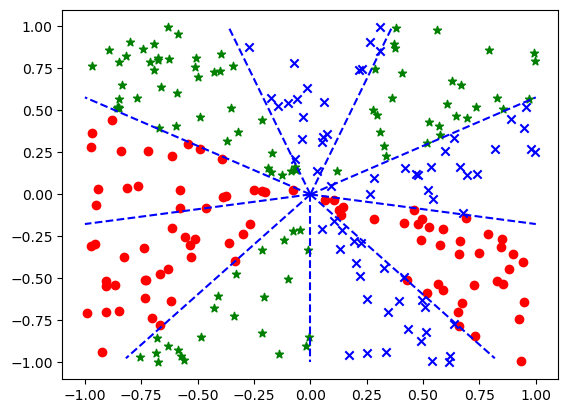

In [3]:
mask0 = targets == 0
plt.scatter(features[mask0, 0], features[mask0, 1],
            color='red',
            marker='o')
mask1 = targets == 1
plt.scatter(features[mask1, 0], features[mask1, 1],
            color='blue',
            marker='x')
mask2 = targets == 2
plt.scatter(features[mask2, 0], features[mask2, 1],
            color='green',
            marker='*')
classes = set(classification_sectors.keys())
if 0 in classes:
    plt.plot([0]*12, np.linspace(0,-1, 12), color='blue', linestyle='dashed')
classes.remove(0)
for i in classes:
    angle = 2*np.pi*i/len(classification_sectors) - np.pi/2
    if -np.pi/2 < angle < np.pi/2:
        x = np.linspace(0, 1, 12)
    else:
        x = - np.linspace(0, 1, 12)
    y = np.tan(angle) * x
    mask = np.abs(y) < 1
    x, y = x[mask], y[mask]
    plt.plot(x, y, color='blue', linestyle='dashed')
plt.show()

L'enjeu est de trouver un modèle permettant de séparer correctement les données bleues (croix) des données rouges (points). On va construire un [réseau de neurones artificiels](https://fr.wikipedia.org/wiki/R%C3%A9seau_de_neurones_artificiels) pour résoudre ce problème de classification.

## Différentes fonctions de coût pour différentes tâches

### Classification multi-label et entropie de mélange (_cross-entropy_)

La couche de sortie pourrait être une couche de taille `1` si on voulait calculer la classe `0`, `1` ou `2` sous la forme d'un entier. On va plutôt représenter cette classe sous la forme d'un [vecteur _one-hot_](https://fr.wikipedia.org/wiki/Encodage_one-hot) qui fait correspondre chaque classe avec un vecteur n'ayant qu'un seul chiffre `1` entouré seulement de `0`. Par exemple la correspondance 

 - `0` $\rightarrow$ `001`
 - `1` $\rightarrow$ `010`
 - `2` $\rightarrow$ `100`
 
est un encodage _one-hot_ valide à trois classes. C'est celui que l'on va choisir. Cette représentation permet de généraliser facilement les calculs qui vont suivre aux autres cas d'usage des réseaux de neurones.

```{admonition} Réseau (2,4,3)
:class: hint

La représentation _one-hot_ permet aussi d'avoir une couche de sortie contenant `3` neurones. En choisissant une couche cachée de taille `4`, on crée le réseau de neurones de taille `(2,4,3)` : `2` neurones d'entrée, `4` dans une seule couche cachée, et `3` neurones de sortie. Voilà la raison du choix d'une classification ternaires comme tâche : on ne voulait pas du cas un peu trop simplistes de un seul neurone de sortie, et on voulait trois valeurs différentes de neurones par couche. 

Les paramètres `(2,4,3)` peuvent être considéré comme les seuls hyperparamètres de notre réseau de neurones à ce niveau de compréhension. Il y aura d'autres hyperparamètres dans la pratique : le _learning parameter_ $\alpha$ ou $\eta$, le nombre d'époques et la taille des mini-batches, qui sont plutôt des paramètres liés à l'entraînement des données, et non pas à la structure du réseau.
```

In [ ]:
def one_hot_encoding(array):
    """Transform an array of integers into a one-hot encoding array."""
    arrayset = sorted(set(array))
    array2onehot = {i: [0]*i + [1] + [0]*(len(arrayset)-i-1)
                    for i in arrayset}
    onehot = [array2onehot[x] for x in array]
    return np.array(onehot)

def one_hot_decoding(array):
    """Transform a one-hot encoded array to an array of classes."""
    array2onehot = {i: [0]*i + [1] + [0]*(array.shape[1]-i-1)
                    for i in range(array.shape[1])}
    onehot2class = {tuple(v): k for k, v in array2onehot.items()}
    classes = [onehot2class[tuple(line.tolist())] for line in array]
    return classes

In [ ]:
targets = one_hot_encoding(targets)
targets[:5]

In [ ]:
one_hot_decoding(targets[:5])

## _Feed-forward propagation_ (propagation avant)

## Construction du réseau

Un réseau de neurones n'est rien d'autre qu'une succession de matrices, qui vont projeter les états successifs les uns dans les autres, et leur appliquer une fonction non-linéaire (quelque chose qui n'est pas une droite) appelée fonction d'activation. À chaque matrice va correspondre ce que l'on appelle une couche de neurones. Pour les calculs, chaque couche de neurones est un simple vecteur (un ensemble de valeurs réelles manipulées toutes ensemble) dont chaque coordonnée est appelée _neurone_. Le nombre de neurones de chaque couche est déterminé par la taille de la matrice permettant de passer de la couche précédente à la couche suivante.

On peut bien évidemment raisonner dans l'autre sens, et définir le nombre de neurones que l'on souhaite dans chaque couche, et adapter ensuite les tailles des matrices de sortes que les dimensions soient manipulées correctement.

```{admonition} Multiplication matricielle et changement de dimension
:class: hint

Rappelons que le produit de la matrice $W^{\left(1\right)}$ de taille $m\times p$ ($m$ lignes et $p$ colonnes) par la matrice $W^{\left(2\right)}$ de taille $p\times n$ ($p$ lignes et $n$ colonnes, même nombre de lignes de $W^{\left(2\right)}$ que de colonnes de $W^{\left(1\right)}$) va produire la matrice $W^{\left(3\right)}$ de taille $m\times n$, selon la formule

$$
W^{\left(3\right)}_{ij} = \sum_{k=1}^{p} W^{\left(1\right)}_{ik} W^{\left(2\right)}_{kj}
$$

où $ij$ représente la $i$-ième ligne et $j$-ième colonne de la matrice $W^{\left(3\right)}$. De même, la multiplication _à gauche_ d'un vecteur de taille $m$ par une matrice $W$ de taille $m\times n$ va produire un vecteur de taille $n$

$$
\overleftarrow{x}\cdot W = \overleftarrow{y} \Leftrightarrow y_i = \sum_{k=1}^{n}x_{k} W_{kj} 
$$

tandis que la multiplication _à droite_ va produire un vecteur de taille $m$

$$
W\cdot \overrightarrow{x} = \overrightarrow{y} \Leftrightarrow y_i = \sum_{k=1}^{m}W_{ik} x_{k}
$$
```

Comme les matrices mélangent tous les éléments d'un vecteur pour en construire un autre, on parle de _réseau de neurones dense_ pour dire que chaque neurone d'une couche est connecté à tous les neurones de la couche suivante. 

```{admonition} Représentation des vecteurs et numpy
:class: warning

En général, un vecteur $\overleftarrow{x}$ que l'on va multiplier à gauche va être représenté par un vecteur _ligne_ de taille $1\times n$, tandis qu'un vecteur $\overrightarrow{x}$ que l'on va multiplier à droite va être représenté par un vecteur _colonne_ de taille $n\times 1$.

Attention à ces manipulations dans `numpy` ! La méthode `numpy.array.shape` renvoie un tuple d'entier représentant les dimensions le long de chaque axe. Sauf que `numpy` définit aussi un tableau sous la forme `(n,)`. Ce dernier pourra être utilisé comme un vecteur colonne ou ligne indiféremment.

Dans la suite on n'utilisera que des vecteurs ayant `(n,1)` ou `(1,n)` depuis la méthode `shape`. Cela permet de mieux visualier les dimensions des différentes couches de neurones, et des matrices qui les manipulent.
```

Deux couches de neurones jouent un rôle particulier : la couche d'_input_/entrée et la couche d'_output_/sortie. En effet, ces deux couches sont imposées par le problème à résoudre. Dans notre cas, la couche d'entrée est un vecteur de taille `2`, puisqu'il n'y a que deux paramètres/_features_. On dira qu'il y a deux neurones d'entrée. 

Ces deux couches de sortie et d'entrée étant imposée, il nous reste à transformer l'une dans l'autre. On peut le faire directement, ou on peut le faire en passant par un nombre non-imposé de couches de neurones. Ces couches s'appellent les _couches cachées_ du réseaux de neurones. Dans la suite on va choisir la représentation la plus simple, à une seule couche cachée. On va choisir, parce que notre tâhe est simple et parce que notre but est l'illustration des mécanismes d'apprentissage et non pas la perspicacité de l'apprentissage résultant, `4` neurones dans cette seule couche cachée.

Attention aux dimensions (`shape` dans `numpy`) des vecteurs : on écrit chaque point à l'aide d'un vecteur horizontal 

Maintenant que l'on a construit les vecteurs d'entrée et de sortie, on peut construite la couche cachée, de dimension `4`. La couche d'entrée est de dimension

In [7]:
features.shape

(250, 2)

dont la première valeur représente le nombre d'exemples qui ne nous concerne pas ici. On a donc `2` neurones d'entrée. Pour passer à `4` neurones dans la couche cachée, il suffit de multiplier le vecteur d'entrée à gauche par une matrice $W^{\left(1\right)}_{2\times 4}$ de taille $2\times 4$ et de faire la produit matriciel avec le vecteur d'entrée.

On obtient donc un vecteur de taille `4`. Ce vecteur peut ensuite être convertit en un vecteur de taille similaire au vecteur de sortie, c'est-à-dire de taille `3`, à l'aide d'une matrice $W^{\left(2\right)}_{4\times 3}$ de taille $4\times 3$, pour s'adapter aux dimensions de sortie

In [8]:
targets.shape

(250, 3)

Reste alors à choisir ces matrices, qui vont servir à la prédiction. On les choisit au départ aléatoire (à moins que l'on ait de bonne raison de choisir certains ou tous les poids) et on va entraîner le modèle à améliorer ces poids de sorte que la prédiction soit meilleure après l'entraînement.

In [9]:
size_hidden = 4
W1 = rng.random((features.shape[1], size_hidden))
W2 = rng.random((size_hidden, targets.shape[1]))
W1.shape, W2.shape

((2, 4), (4, 3))

La fonction non-linéaire que l'on va choisir est une sigmoïde $\sigma\left(x\right)$, qui n'est autre que la fonction de la régression logistique :

$$
\sigma\left(x\right) = \frac{1}{1+e^{-x}}
$$

de sorte qu'à la sortie d'une couche de poids $W$, on aura $\overleftarrow{y}=\sigma\left(\overleftarrow{x}\cdot W\right)$. Ce vecteur peut ensuite être envoyé dans une nouvelle couche, et on recommence l'opération. La seule subtilité dans cette opération non-linéaire est qu'elle n'est pas appliquée sur la matrice elle-même, mais élément par élément. Ainsi, quand on écrit $\overleftarrow{y}=\sigma\left(\overleftarrow{x}\cdot W\right)$, on sous-entend que l'on calcule le vecteur $y$ élément par élément, et que la fonction $\sigma\left(x\right)$ est en fait un vecteur dont l'élément $\sigma_i$ s'écrit $\sigma_i=\sigma\left(x_i\right)$

Dans la pratique, on ne se soucie pas trop de cette subtilité, puisque [`numpy` pratique le broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html), qui est précisémment l'opération ci-dessus. On applique simplement `nn.sigmoid(x)` sur le tableau `x` (`nn` est une librairie locale).

Prédire l'état du vecteur en fin de chaîne consiste à appliquer les opérations de multiplications matricielle, suivies des opérations non linéaires. On va supposer qu'il y a deux couches, de paramètres $W^{\left(1\right)}_{ij}$ pour la première couche, et $W^{\left(2\right)}_{ij}$ pour la seconde couche. Appelons $x_i$ ou $x^{\left(0\right)}_i$ le vecteur d'entrée (dont le nombre de coordonnées correspond au nombre de _features_) et $y_i$ ou $x^{\left(L\right)}_i$ (pour nous le nombre total de couche $L=2$) le vecteur de sortie associé.

Appelons finalement $z_i$ les vecteurs entre les deux couches d'entrée et de sortie (on appelle ces couches des couches cachées). En appelant $\pi$ l'opération représentant le produit matriciel, on aura alors,

$$
x^{\left(1\right)}_i = \sigma^{\left(1\right)}\left(z^{\left(1\right)}_i\right)
\;\;;\;\;
z^{\left(1\right)}_i = \pi_i\left(x^{\left(0\right)}\right) = \sum_{k} x^{\left(0\right)}_k W^{\left(1\right)}_{ki}
$$

pour la première couche cachée exprimée en fonction des 

$$
x^{\left(2\right)}_i = \sigma^{\left(2\right)}\left(z^{\left(2\right)}_i\right)
\;\;;\;\;
z^{\left(2\right)}_i = \pi_i\left(x^{\left(1\right)}\right) = \sum_{k} x^{\left(1\right)}_k W^{\left(2\right)}_{ki}
$$

pour la deuxième couche cachée, ..., et finalement

$$
y_i = x^{\left(L\right)}_i = \sigma^{\left(L\right)}\left(z^{\left(L\right)}_i\right)
\;\;;\;\;
z^{\left(L\right)}_i = \pi_i\left(x^{\left(L\right)}\right) = \sum_{k}x^{\left(L-1\right)}_k W^{\left(L\right)}_{ki}
$$

pour la dernière couche notée $y_i$. Dans notre cas $y_i = x^{\left(2\right)}_i$ puisqu'on n'a qu'une seule couche cachée. Ici, on a voulu généraliser autant que possible. Il est même possible de changer la fonction non-linéaire en fonction des couches (on verra un exemple plus loin).

Remarquons que le vecteur représentant la couche $^{\left(n\right)}$ s'exprime comme la composition de plusieurs opérations appliquées sur le vecteur d'entrée : 

$$
x^{\left(n\right)} = \left(\sigma^{\left(n\right)} \circ \pi \circ \sigma^{\left(n-1\right)} \circ \cdots \circ \sigma^{\left(1\right)} \circ \pi\right)\left(x^{\left(0\right)}\right)
$$ (composition_layers)

Implémentons ce résultat dans `numpy`. Le produit matriciel s'écrit `@`. On fait attention au fait que `features` et `targets` contiennent en pratique tous les exemples. On procède donc exemple par exemple pour reconstruire à la fin la matrice de prédictions. 

In [10]:
def forward(x, weights):
    layers = [x]
    for weight in weights:
        y = layers[-1] @ weight
        layers.append(nn.sigmoid(y))
    return layers

weights = [W1, W2]

predictions = []
for x in features:
    pred = forward(x.reshape(1, features.shape[1]), weights )
    predictions.append(pred[-1])
predictions = np.concatenate(predictions)
predictions.shape

(250, 3)

```{admonition} _Broadcasting_ dans numpy
:class: hint
L'intérêt du broadcasting de `numpy` peut se matérialiser ici aussi : on n'est pas obligé d'écrire la boucle sur les lignes (c'est-à-dire les exemples) pour calculer toutes les prédictions. On peut ainsi garder toute les valeurs de tous les neurones dans une simple liste, dont chaque élément représente la couche en question, pour l'ensemble des exemples disponibles.

Attention toutefois conserver autant de valeurs de neurones peut être très coûteux en mémoire, n'oublions pas que l'on a affaire à des nombres flottants, et possiblement une grande quantité !  
```

In [11]:
layers = forward(features, weights)
layers[-1].shape

(250, 3)

Vérifions que l'on a bien calculé la même chose que précédemment (attention aux formats de données, on ne prend que la dernière couche dans `predictions` tandis que l'on conserve toutes les couches dans la fonction `forward`)

In [12]:
predictions[:5, :]

array([[0.73422015, 0.75802727, 0.79171161],
       [0.76497271, 0.797874  , 0.84215469],
       [0.73871453, 0.76338831, 0.80198085],
       [0.75776482, 0.78896661, 0.83085141],
       [0.73107173, 0.75217364, 0.79137154]])

In [13]:
layers[-1][:5, :]

array([[0.73422015, 0.75802727, 0.79171161],
       [0.76497271, 0.797874  , 0.84215469],
       [0.73871453, 0.76338831, 0.80198085],
       [0.75776482, 0.78896661, 0.83085141],
       [0.73107173, 0.75217364, 0.79137154]])

Cela ne ressemble pas vraiment à ce que l'on attend, à savoir une matrice qui ne contient que des `1` ou des `0` par colonne, de sorte que l'on saura à quelle classe appartient le point considéré. On utilise donc la fonction `np.round` qui va projeter les valeurs obtenues sur les valeurs limites `0` ou `1` puisque la fonction sigmoide est définie sur l'intervalle $\left[0, 1\right]$.

In [14]:
def predict(x, weights):
    return np.round(forward(x, weights)[-1]).astype(int)

predict(features, weights)[:5]

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

Il nous reste maintenant à entraîner le modèle, de sorte qu'il apprenne à distinguer les différentes classes, ce qu'il n'a pas l'air de faire pour le moment...

## _Back-propagation_ (rétropropagation du gradient)

L'apprentissage des réseaux de neurones se fonde sur l'algorithme de back-propagation. Comme dans le cas de la régression ou de la classification classique, on cherche à minimiser une fonction d'erreur (on ne l'a pas encore donnée). Or minimiser une fonction peut se faire grâce à l'[algorithme de descente de gradient](https://en.wikipedia.org/wiki/Gradient_descent) ou [sa version stochastique](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Cet algorithme a été introduit dans le chapitre sur la [régression logistique](../reg/logistic_regression). 

Pour utiliser la descente de gradient, on doit calculer la dérivée de la fonction de coût $\ell$ par rapport à tous les paramètres que l'on veut optimiser. Pour les réseaux de neurones, les paramètres à optimiser sont les coefficients des matrices de poids $W^{\left(n\right)}$ et l'algorithme de descente de gradient s'écrira alors sous la forme de la mise à jour des poids à l'étape $n+1$ par rapport à l'étape $n$ (rappelons que l'exposant $^{\left(n\right)}$ indique quant à  lui la couche neuronale)

$$
W^{\left(n\right)}_{n+1} = W^{\left(n\right)}_n - \eta\left.\frac{\partial \ell\left(y^{\text{true}}, y^{\text{pred}}\right)}{\partial W^{\left(n\right)}}\right|_{W^{\left(n\right)} = W^{\left(n\right)}_n}
$$

Ces dérivées s'expriment comme des fonctions sur les poids des différentes couches précédentes, prises dans le sens inverse de la propagation, d'où le nom de rétropropagation du gradient pour désigner l'algorithme de descente de gradient dans le cadre des réseaux de neurones.

### Réseau à une couche : exemple de rétropropagation de gradient

Pour bien comprendre l'algorithme de rétropropagation de gradient, calculons tout d'abord les mises à jour pour un réseau de neurones à une seule couche cachée.

On va choisir la fonction de coût la plus simple, à savoir l'écart quadratique entre les prédictions et les valeurs vraies

$$
\ell\left(y_{\text{true}}, y_{\text{pred}}\right) = \frac{1}{2}\sum_{i=1}^{N}\left(y_{\text{pred}}^i - y_{\text{true}}^i\right)^2
$$

où $i$ est l'indice d'exemple. 

```{admonition} 
:class: warning

Attention, notre fonction de coût ne fonctionne que pour des valeurs de $y_{\text{pred}}$ non entières ; il faut qu'elle soit continue sinon on ne peut pas calculer ses dérivées. On ne va donc pas utiliser `numpy.round` avant de calculer l'erreur sur l'ensemble des résultats. Il y a souvent une différence entre ce que _sort_ le réseau de neurones, et ce que _prédit_ le réseau de neurones, et on ne fait pas toujours la distinction.

Dans la pratique pour des classifications on prend d'autres fonctions de coût / _loss_ / risque, par exemple la [fonction de log-vraissemblance](https://math.stackexchange.com/questions/2503428/derivative-of-binary-cross-entropy-why-are-my-signs-not-right) qui aura d'ailleurs une expression assez proche de ce que l'on va trouver ci-dessous.
```

Soit alors à calculer

$$
\frac{\partial \ell}{\partial W^{\left(2\right)}} = \frac{\partial \ell}{\partial y_{\text{pred}}^i}\frac{\partial y_{\text{pred}}^i}{\partial W^{\left(2\right)}} = \left(y_{\text{pred}}^i - y_{\text{true}}^i\right) \frac{\partial y_{\text{pred}}^i}{\partial W^{\left(2\right)}}
$$

par application de la [règle de chaîne des fonctions composées](https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_de_d%C3%A9rivation_des_fonctions_compos%C3%A9es), et 

$$
\frac{\partial \ell}{\partial W^{\left(1\right)}} =  \left(y_{\text{pred}}^i - y_{\text{true}}^i\right) \frac{\partial y_{\text{pred}}^i}{\partial W^{\left(1\right)}}
$$

et ainsi de suite si on avait plusieurs autres couches.

Pour notre réseau à une seule couche cachée, on a, depuis {eq}`composition_layers`

$$
\begin{align}
y^{i}_{\text{pred}} &= \left(\sigma^{\left(2\right)} \circ \pi_{W^{\left(2\right)}} \circ \sigma^{\left(1\right)} \circ \pi_{W^{\left(1\right)}} \right)\left(x^{\left(0\right)}\right) \\
&= \left(\sigma^{\left(2\right)} \circ \pi_{W^{\left(2\right)}} \right)\left(\left(\sigma^{\left(1\right)} \circ \pi_{W^{\left(1\right)}}\right)\left(x^{\left(0\right)}\right)\right) \\
&= \left(\sigma^{\left(2\right)} \circ \pi_{W^{\left(2\right)}} \right)\left(x^{\left(1\right)}\right)
\end{align}
$$

puisque $x^{\left(1\right)} = \left(\sigma^{\left(1\right)} \circ \pi_{W^{\left(1\right)}}\right)\left(x^{\left(0\right)}\right)$ par définition de la première couche cachée. On a donc 

$$
\begin{align}
\frac{\partial y_{\text{pred}}^i}{\partial W^{\left(2\right)}} 
&= \left.\frac{\partial \sigma^{\left(2\right)}\left(z\right)}{\partial z}\right|_{z=\pi_{W^{\left(2\right)}} \left(x^{\left(1\right)}\right)}\frac{\partial \pi_{W^{\left(2\right)}}}{\partial W^{\left(2\right)}} \\
&= \left.\frac{\partial \sigma^{\left(2\right)}\left(z\right)}{\partial z}\right|_{z=z^{\left(2\right)}} \frac{\partial \pi_{W^{\left(2\right)}}}{\partial W^{\left(2\right)}}
\end{align}
$$

et de même on aura, en utilisant les mêmes astuces

$$
\frac{\partial y_{\text{pred}}^i}{\partial W^{\left(1\right)}} = \frac{\partial y_{\text{pred}}^i}{\partial W^{\left(2\right)}} \left.\frac{\partial \sigma^{\left(1\right)}\left(z\right)}{\partial z}\right|_{z=z^{\left(1\right)}} \frac{\partial \pi_{W^{\left(1\right)}}}{\partial W^{\left(1\right)}}
$$

et on voit donc que l'on peut procéder par couche, de la plus proche de la sortie vers la couche d'entrée. C'est le principe de la rétropropagation de gradient à travers les couches des réseaux de neurones.

Pour la fonction sigmoide on a 

$$
\sigma\left(x\right) = \frac{1}{1+e^{-x}}
\Rightarrow
\frac{d\sigma}{dx} = \sigma\left(x\right)\left(1-\sigma\left(x\right)\right)
$$

et on a donc 

$$
\left.\frac{\partial \sigma^{\left(n\right)}\left(z\right)}{\partial z}\right|_{z=z^{\left(n\right)}}
= x^{\left(n\right)}\left(1-x^{\left(n\right)}\right)
$$

puisque $\sigma^{\left(n\right)}\left(z^{\left(n\right)}\right) = x^{\left(n\right)}$ par définition du réseau de neurones et si la fonction d'activation est une sigmoide pour la couche $^{\left(n\right)}$. C'est bien évidemment le cas pour nous, mais on aurait pu choisir une autre fonction d'activation dans le cas général.

De même, pour les produits matriciels, on aura 

$$
\frac{\partial \pi_{W^{\left(n\right)}}}{\partial W^{\left(n\right)}} = x^{\left(n-1\right)}
$$

d'après nos définitions.

Rassemblant les termes, on a donc

$$
\frac{\partial \ell}{\partial W^{\left(2\right)}} = \left(x^{\left(1\right)}\right)^{T} \cdot \left[x^{\left(2\right)}\left(1-x^{\left(2\right)}\right)\left(y_{\text{pred}}^i - y_{\text{true}}^i\right)\right]
$$

$$
 \\
\frac{\partial \ell}{\partial W^{\left(1\right)}} = \left(x^{\left(0\right)}\right)^{T} \cdot \left[ x^{\left(1\right)}\left(1-x^{\left(1\right)}\right)\frac{\partial \ell}{\partial W^{\left(2\right)}}\right]
$$

### Cas général

Appelons $\ell\left(y^{\text{true}}, y^{\text{pred}}\left(\alpha\right)\right)$ cette fonction d'erreur (_loss_ en anglais), avec $\alpha$ l'ensemble des paramètres qui ont permis de calculer la _target_ prédite $y_{\text{pred}}$. On veut donc calculer la dérivée de $\ell$ par rapport à $\alpha$. Par la [règle de dérivation en chaîne](https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_de_d%C3%A9rivation_des_fonctions_compos%C3%A9es), on a

$$
\frac{d\ell}{d\alpha} = \frac{d\ell\left(y^{\text{pred}}\right)}{dy^{\text{pred}}}\frac{dy^{\text{pred}}}{d\alpha}
$$

Pour nous, les paramètres qu'il faut optimiser sont les poids $W_{ij}$ des matrices, et les biais $b_i$, pour chacune des couches. Calculons les dérivées en partant des dernières couches. On obtient que l'erreur à la couche $n-1$ s'écrit (voir l'[article Wikipédia sur la rétro-propagation de gradient](https://fr.wikipedia.org/wiki/R%C3%A9tropropagation_du_gradient))

$$
e_j^{(n-1)} = \left.\frac{d\sigma^{(n-1)}}{dz}\right|_{z_j^{(n-1)}}\sum_k W_{ik}^{(n)} e_k^{(n)}
$$

et pour la dernière couche (la couche de sortie donc), on aura 

$$
e_i^{(L)} = \left.\frac{d\sigma^{(L)}}{dz}\right|_{z_i^{(L)}}\frac{d\ell\left(y^{\text{pred}}_i\right)}{dy^{\text{pred}}_i} 
$$

qui va dépendre de la fonction d'erreur. On utilise ensuite l'algorithme de descente de gradient stochastique, pour écrire que la mise à jour des coefficients

$$
W_{ij}^{(l)} = W_{ij}^{(l)} - \eta x_i^{(l-1)}\otimes e_j^{(l)}
$$

avec un petit paramètre $\eta$ permet d'atteindre un minimum _local_ de la fonction d'erreur.

Notons que l'opération de calcul des erreurs associées à chaque couche est un simple produit matriciel (`numpy.dot` ou `numpy.inner`) tandis que la mise à jour des poids des matrices utilise un produit tensoriel $\otimes$, en utilisant `numpy.outer`.

In [15]:
def loss(y_true, y_pred):
    return np.mean((y_pred - y_true)**2 / 2, axis=0)

def loss_gradient(y_true, y_pred):
    # take the transpose: we want a column vector
    # axis:0 is the example/minibatch axis
    return np.mean(y_pred - y_true, axis=0).reshape(y_true.shape[1], 1)

activation = nn.sigmoid
activation_gradient = nn.sigmoid_gradient

def print_shape(list_array):
    print('-'*12)
    for array in list_array:
        print(array.shape)
    print('#'*12)
    return None

def train(x, y, weights, learning_rate=0.001):
    assert x.shape[0] == y.shape[0]
    assert x.shape[1] == weights[0].shape[0]
    assert y.shape[1] == weights[-1].shape[1]
    # forward propagation
    # keep derivatives and neurons
    # along the propagation
    derivatives, neurons = [], [x]
    for weight in weights:
        neuron = neurons[-1] @ weight
        derivatives.append(activation_gradient(neuron).T)
        neurons.append(activation(neuron))
    # error of the last layer
    errors = [loss_gradient(y, neurons[-1]) * derivatives[-1]]
    for derivative, weight in zip(derivatives[:-1][::-1], weights[1:][::-1]):
        derivative_sum = np.mean(derivative, axis=0).reshape(derivative.shape[1], 1)
        errors.append(weight @ errors[-1] * derivative_sum)
    errors = errors[::-1]
    updates = [np.outer(x.T, e.T)
               for e, x in zip(errors[:], neurons[:-1])]
    for weight, update in zip(weights, updates):
        weight -= learning_rate * update
    return weights

train(features[0, :].reshape(1, features.shape[1]),
      targets[0, :].reshape(1, targets.shape[1]),
      weights)

[array([[0.15604199, 0.28256901, 0.6796628 , 0.35443962],
        [0.79752453, 0.2868663 , 0.85387721, 0.26172985]]),
 array([[0.48569064, 0.4312095 , 0.8435682 ],
        [0.6835695 , 0.3466686 , 0.71449898],
        [0.04813382, 0.6615516 , 0.90684896],
        [0.74209049, 0.72262379, 0.11195108]])]

Appliquer plusieurs fois l'algorithme d'entraînement permet de calculer des valeurs des matrices de plus en plus prédictives (normalement, c'est-à-dire quand tout se passe bien). On appelle _époque_ le nombre de fois que l'algorithme va voir tous les examples.

In [16]:
nb_epochs = 12
for _ in range(nb_epochs):
    for x, y in zip(features, targets):
        train(x.reshape(1, features.shape[1]),
              y.reshape(1, targets.shape[1]),
              weights)
    y_pred = forward(x, weights)[-1]
    print(loss(targets, y_pred))

[0.20029143 0.24168001 0.2266358 ]
[0.19837512 0.23918787 0.22534691]
[0.19645352 0.23667024 0.22404384]
[0.19452838 0.23412911 0.22272706]
[0.19260146 0.2315666  0.22139707]
[0.19067457 0.22898495 0.22005441]
[0.18874955 0.22638651 0.21869965]
[0.18682825 0.22377372 0.21733339]
[0.18491255 0.22114912 0.21595627]
[0.18300433 0.21851534 0.21456895]
[0.18110545 0.21587505 0.21317215]
[0.1792178  0.21323102 0.21176658]


On voit qu'à chaque époque, la fonction de coût se réduit, pour chaque valeur du vecteur de sortie. On va tenter de calculer les classes maintenant que l'on a entraîné le modèle. On définit pour cela la précision, qui consiste à compter le nombre moyen de fois que l'on a prédit la bonne classe. Rappelons que la classe est calculée à l'aide de la fonction `numpy.round` depuis la sortie du réseau de neurones.

In [17]:
def accuracy(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "arrays must have same shape"
    return sum(np.sum(line_y_true == line_y_pred) == line_y_pred.shape[0]
               for line_y_true, line_y_pred in zip(y_true, y_pred)) / y_true.shape[0]

accuracy(targets, predict(features, weights))

0.0

Entraînons maintenant le modèle de nombreuses fois, et récupérons la valeur de l'erreur et de la précision à chaque époque

In [18]:
accuracies, losses = [], []
nb_epochs = 250
for _ in range(nb_epochs):
    for x, y in zip(features, targets):
        train(x.reshape(1, features.shape[1]),
              y.reshape(1, targets.shape[1]),
              weights)
    y_pred = predict(features, weights)
    losses.append(sum(loss(targets, y_pred)))
    accuracies.append(accuracy(targets, y_pred))

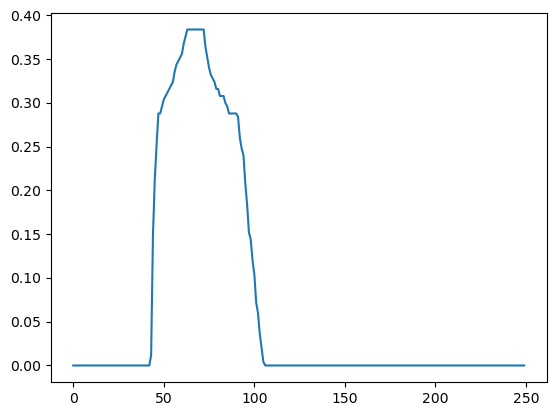

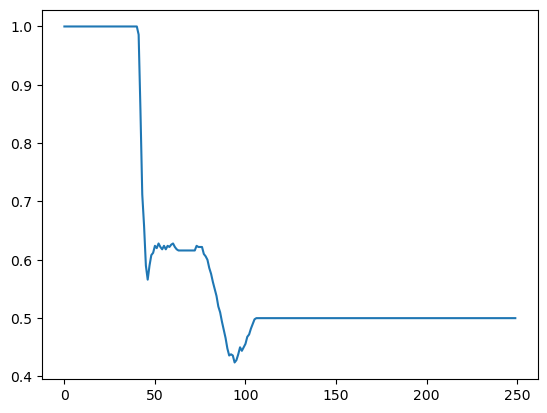

<Figure size 640x480 with 0 Axes>

In [19]:
plt.plot(range(nb_epochs), accuracies)
plt.show()
plt.clf()
plt.plot(range(nb_epochs), losses)
plt.show()
plt.clf()

## Améliorer les performances des réseaux de neurones

On peut utiliser du batch learning, du early stopping et du dropout pour améliorer facilement les performances des réseaux de neurones. On y reviendra dans les prochains chapitres.

Une autre direction d'amélioration est de construire le réseau de neurones couche par couche. En effet, chaque couche est la simple expression d'une non-linéarité et d'un produit matriciel. Il nous faut pour chaque couche pouvoir propager les informations _forward_/en-avant et les erreurs _backward_/en-arrière. Une abstractions sous forme de classe permettrait de faire cela de façon assez simple. On pourrait ainsi remplacer la dernière couche par une couche qui ne prédirait qu'une seule classe, dans l'esprit de l'encodage _one-hot_ utilisé ci-dessus. Il s'agirait simplement de remplacer la fonction d'activation de la dernière couche par la fonction _softmax_, qui est définie par

$$
\sigma^{\left(L\right)}\left(x\right) =\varphi\left(x_i\right) = \frac{e^{-x_i}}{\sum_i e^{-x_i}}
$$

qui est une généralisation de la fonction sigmoide de la régression logistique employée ci-dessus.

On peut également étudier les différentes fonctions de coût qui permettent d'améliorer les capacités de prédictions des réseaux, en fonction des tâches que l'on souhaite réaliser. Par exemple dans le cas d'une classification à plusieurs classes, on peut utiliser l'[entropie croisée / _cross-entropy_](https://en.wikipedia.org/wiki/Cross-entropy#Cross-entropy_minimization)

$$
\ell\left(y^{\text{true}}, y^{\text{pred}}\right) = - \sum_{i} y^{\text{true}}_i \log y^{\text{pred}}_i
$$

(attention, cette fonction ne supporte pas d'avoir $y^{\text{pred}}_i = 0$).

Enfin, une large panoplie de résultats mathématiques concerne l'optimisation de la procédure d'optimisation. Optimiser en mathématique signifie trouver le minimum ou le maximum d'une fonction de coût soumise à des contraintes. On a utilisé ci-dessus une version simplifiée de la descente de gradient, mais [nouveaux résultats sur la descente stochastique de gradient](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) permettent d'améliorer les temps de convergence, et la souplesse algorithmique des réseaux de neurones.

## Classification multi-classes

Les réseaux de neurones dense constituent une approche intéressante pour les classifications à plusieurs classes. Dans ce cas, la fonction de coût est une [entropie croisée](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) et la fonction d'activation de la dernière couche est une [fonction softmax](). On prend de plus comme fonction d'activation une fonction [ReLU]() pour la fonction d'activation de la première couche. Recommençons l'entraînement pour notre problème dans ce cas.

On peut [montrer que l'erreur sur la dernière couche](https://stats.stackexchange.com/questions/370723/how-to-calculate-the-derivative-of-crossentropy-error-function) dans ce cas s'écrit simplement

$$
e^{\left(2\right)}_j = y^{\text{true}}_j - y^{\text{pred}}_j
$$

tandis que l'erreur sur les couches précédente va se propager comme d'habitude, avec entre autre que la dérivée de la fonction softmax vérifie la même propriété que la fonction, à savoir $\varphi^{\prime}\left(x_i\right) = \varphi\left(x_i\right)\left(1-\varphi\left(x_i\right)\right)$.

In [20]:
def forward(x, weights):
    assert len(weights) == 2
    layer1 = nn.sigmoid(x @ weights[0])
    layer2 = nn.softmax(layer1 @ weights[-1])
    return (layer1, layer2)

def loss(y_observed, y_true):
    return np.sum(y_true * np.log(y_observed))

def train(x, y, weights, learning_rate=0.001, dropout=0.1):
    assert x.shape[0] == y.shape[0]
    assert x.shape[1] == weights[0].shape[0]
    assert len(weights) == 2, 'only one hidden layer is configurated'
    assert y.shape[1] == weights[-1].shape[1]
    # forward propagation
    layer1 = nn.sigmoid(x @ weights[0])
    dropout = rng.random(layer1.shape) >= dropout
    layer1 *= dropout
    layer2 = nn.softmax(layer1 @ weights[-1])
    # error of the last layer
    error2 = (y - layer2).T
    # backward propagation
    error1 = (layer1 * (1 - layer1)).T * (weights[-1] @ error2)
    error1 *= dropout.T
    # summation over minibatch
    weights[0] -= learning_rate * np.outer(np.mean(x, axis=0),
                                           np.mean(error1, axis=1))
    weights[-1] -= learning_rate * np.outer(np.mean(layer1, axis=0),
                                            np.mean(error2, axis=1))
    return weights

size_hidden = 48
features, targets = construct_dataset()
targets = one_hot_encoding(targets)
W1 = rng.random((features.shape[1], size_hidden))
W2 = rng.random((size_hidden, targets.shape[1]))
# add bias
W1 = np.vstack([W1, rng.random(W1.shape[1])])
features = np.hstack([features, np.ones((features.shape[0],1))])
weights = [W1, W2]

Cette fois, pour trouver la classe prédite, on va simplement prendre l'argument du maximum de ce que donne le réseau de neurones, puisque la fonction softmax normalise toutes les lignes de résultats, on eput interpréter chaque ligne comme la probabilité que la classe soit dans la case correspondante de l'encodage _one-hot_. 

In [21]:
_, y_pred = forward(features, weights)
y_pred[:5, :]

array([[0.11335961, 0.69367586, 0.19296453],
       [0.23881922, 0.51188429, 0.24929649],
       [0.1466494 , 0.61874992, 0.23460068],
       [0.10110305, 0.69562303, 0.20327392],
       [0.14559443, 0.61730061, 0.23710497]])

La valeur la plus probable est alors la valeur la plus grande. Ce maximum par ligne se trouve à l'aide de la méthode `numpy.argmax(array, axis=1)`. La précision est alors le pourcentage de classes correctement prédites.

In [22]:
def accuracy(y_pred, y_true):
    return np.sum(np.argmax(y_pred, axis=1) == np.argmax(targets, axis=1)) / y_pred.shape[0]

Entraînons maintenant ce modèle sur plusieurs époques pour voir s'il apprend quelque chose.

In [23]:
nb_epochs, batch_size = 500, 64
accuracies, losses = [], []
for _ in range(nb_epochs):
    train(features, targets, weights)
    _, y_pred = forward(features, weights)
    accuracies.append(accuracy(y_pred, targets))
    losses.append(loss(y_pred, y))

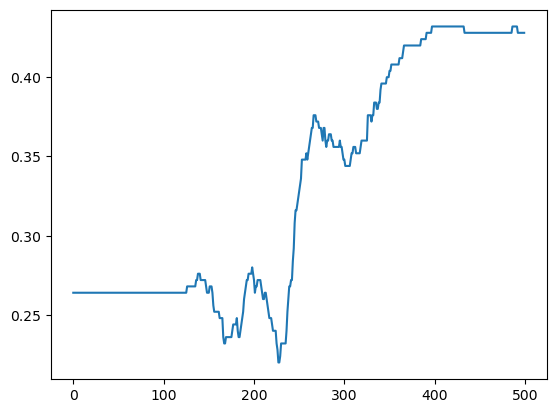

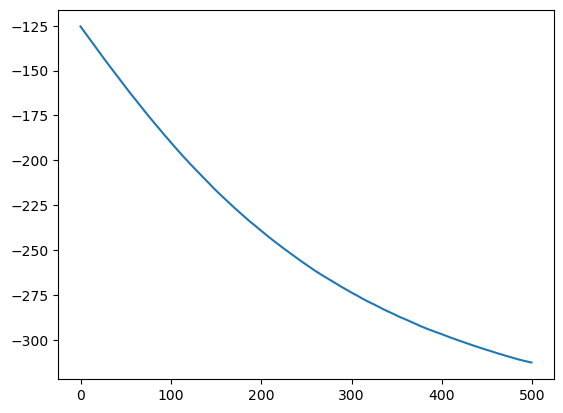

<Figure size 640x480 with 0 Axes>

In [24]:
plt.plot(range(nb_epochs), accuracies)
plt.show()
plt.clf()
plt.plot(range(nb_epochs), losses)
plt.show()
plt.clf()

In [25]:
_, y_pred = forward(features, weights)
accuracy(y_pred, targets)

0.428